In [1]:
import math, random

import gym
import numpy as np

import torch
import torch.nn as nn
import torch.optim as optim
import torch.autograd as autograd 
import torch.nn.functional as F

In [30]:
#basic
import numpy as np
import pandas as pd
#sklearn
from sklearn.manifold import TSNE
from sklearn.decomposition import IncrementalPCA
from sklearn.cluster import KMeans
from sklearn.cluster import Birch
from sklearn import metrics
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import balanced_accuracy_score
#image processing
from skimage.future import graph
from skimage import data
from skimage.filters import threshold_otsu
from skimage.segmentation import clear_border
from skimage.measure import label, regionprops
from skimage.segmentation import felzenszwalb
from skimage.morphology import closing, square
from skimage.color import label2rgb, rgb2gray, gray2rgb
from skimage.transform import resize
from skimage.transform import rescale
#visialization
from PIL import Image
import cv2
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import seaborn as sns
sns.set_palette("Set2")
#skmultiflow
from skmultiflow.trees import HoeffdingTreeClassifier
from skmultiflow.trees import HoeffdingAdaptiveTreeClassifier
from skmultiflow.rules import VeryFastDecisionRulesClassifier
from skmultiflow.trees import ExtremelyFastDecisionTreeClassifier
#scikit 
from scipy.spatial import distance_matrix
from scipy.spatial import distance
#graph
import networkx as nx
#ontology
import owlready2 as owl
#language model
from gensim.models.doc2vec import Doc2Vec, TaggedDocument
#dunn index
import dunn
from sklearn.metrics.pairwise import euclidean_distances
#other
from itertools import count
from joblib import dump, load

import warnings
warnings.filterwarnings("ignore", category=UserWarning)

In [31]:
from IPython.display import clear_output
import matplotlib.pyplot as plt
%matplotlib inline

In [32]:
from gym import spaces

In [33]:
from common.wrappers import make_atari, wrap_deepmind, wrap_pytorch

helping functions

In [34]:
def show_image(img):
    fig, ax = plt.subplots(figsize=(10, 6))
    ax.imshow(img)

In [35]:
def to_shape(a, shape, grayscale=True):
    y_, x_ = shape
    y, x = a.shape[0:2]
    y_pad = (y_-y)
    x_pad = (x_-x)
    if grayscale:
        return np.pad(a,((y_pad//2, y_pad//2 + y_pad%2), 
                         (x_pad//2, x_pad//2 + x_pad%2)
                        ),
                      mode = 'constant')
    else:
        return np.pad(a,((y_pad//2, y_pad//2 + y_pad%2), 
                         (x_pad//2, x_pad//2 + x_pad%2),
                        (0,0)
                        ),
                      mode = 'constant')

In [36]:
def make_video(States,name="test",width=160,height=210,channel=3,fps=30):
    fourcc = cv2.VideoWriter_fourcc(*'XVID') 
    video = cv2.VideoWriter(name+'.avi', fourcc, float(fps), (width,height))

    for i in range(States.shape[0]):
        video.write(States[i])

    video.release()

In [37]:
def visualize_objects(label_image,image):
    # to make the background transparent, pass the value of `bg_label`,
    # and leave `bg_color` as `None` and `kind` as `overlay`
    image_label_overlay = label2rgb(label_image, image=image, bg_label=0)

    fig, ax = plt.subplots(figsize=(10, 6))
    ax.imshow(image_label_overlay)

    for region in regionprops(label_image):
        # take regions with large enough areas
        if region.area >= 1:
            # draw rectangle around segmented coins
            minr, minc, maxr, maxc = region.bbox
            rect = mpatches.Rectangle((minc-0.5, minr-0.5), maxc - minc, maxr - minr,
                                      fill=False, edgecolor='red', linewidth=3)
            ax.add_patch(rect)

    ax.set_axis_off()
    plt.tight_layout()
    plt.show()

In [38]:
def find_objects2(image):
    img = rgb2gray(image)

    # apply threshold
    thresh = threshold_otsu(img)
    reg = closing(img > thresh, square(2))

    # label image regions
    label_image = label(reg)
    
    return label_image

In [39]:
def find_objects3(image):
    img = rgb2gray(image)

    # apply threshold
    thresh = threshold_otsu(img)
    #0.327
    # label image regions
    label_image = label(img > thresh)
    
    return label_image

In [40]:
def find_objects(image):
    img = rgb2gray(image)

    # label image regions
    label_image = label(img > 0.327)
    
    return label_image

In [41]:
def find_cut_objects(image,m_h,m_w,grayscale=True):
    label_image=find_objects(image)
    regions=regionprops(label_image)

    i=len(regions)-1
    for reg in regions:
        i=i+1
        minr, minc, maxr, maxc = reg.bbox
        if int(np.ceil((maxc-minc)/m_w))!=1:
            split_w=np.linspace(0,(maxc-minc),1+int(np.ceil((maxc-minc)/m_w))).astype("int")
            for y in range(int(np.ceil((maxc-minc)/m_w))):
                i=i+1
                label_image[reg.slice][:,split_w[y]:split_w[y+1]][reg.image[:,split_w[y]:split_w[y+1]]]=i
    
    regions=regionprops(label_image)
    i=len(regions)+1
    for reg in regions:
        i=i+1
        minr, minc, maxr, maxc = reg.bbox
        if int(np.ceil((maxr-minr)/m_h))!=1:
            split_h=np.linspace(0,(maxr-minr),1+int(np.ceil((maxr-minr)/m_h))).astype("int")
            for x in range(int(np.ceil((maxr-minr)/m_h))):
                i=i+1
                label_image[reg.slice][split_h[x]:split_h[x+1],:][reg.image[split_h[x]:split_h[x+1],:]]=i


    regions=regionprops(label_image)
    
    if grayscale:
        image=rgb2gray(image)
    
    objects=np.array([np.zeros((m_h,m_w)) for reg in regions])
    for i in range(len(regions)):
        x=regions[i].image.shape[0]
        y=regions[i].image.shape[1]
        objects[i,(m_h-x)//2:(m_h-x)//2+x,(m_w-y)//2:(m_w-y)//2+y]=image[regions[i].slice]
    
    
    return label_image, objects, regions

In [42]:
def regions_to_graph(regions,labels,prox=60):
    #weighted?
    centroids=np.array([reg.centroid for reg in regions])
    if prox==0:
        dist=np.zeros((len(centroids),len(centroids)))
    else:
        dist=distance_matrix(centroids,centroids)
        dist=(dist<prox)*dist
    G = nx.from_numpy_matrix(dist)
    lab={x:str(labels[x]) for x in range(len(centroids))}
    nx.set_node_attributes(G, lab, "feature")
    pos_x={x:int(centroids[x][0]) for x in range(len(centroids))}
    nx.set_node_attributes(G, pos_x, "position_x")
    pos_y={x:int(centroids[x][1]) for x in range(len(centroids))}
    nx.set_node_attributes(G, pos_y, "position_y")
    return G

In [43]:
def graph_to_doc(Graphs,iterations=2,start_tag=0):
    documents=[]
    hashes=None
    for i in range(len(Graphs)):
        if iterations>0:
            hashes=nx.weisfeiler_lehman_subgraph_hashes(Graphs[i], iterations=iterations, node_attr="feature")
            
        Doc=[]
        for node in Graphs[i].nodes:
            Doc=Doc+[Graphs[i].nodes[node]["feature"],"pos_x"+str(Graphs[i].nodes[node]["position_x"]),"pos_y"+str(Graphs[i].nodes[node]["position_y"]),
                    "apr_pos_x"+str(Graphs[i].nodes[node]["position_x"]//5),"apr_pos_y"+str(Graphs[i].nodes[node]["position_y"]//5),
                    Graphs[i].nodes[node]["feature"]+"pos_x"+str(Graphs[i].nodes[node]["position_x"]),
                     Graphs[i].nodes[node]["feature"]+"pos_y"+str(Graphs[i].nodes[node]["position_y"]),
                    Graphs[i].nodes[node]["feature"]+"apr_pos_x"+str(Graphs[i].nodes[node]["position_x"]//5),
                     Graphs[i].nodes[node]["feature"]+"apr_pos_y"+str(Graphs[i].nodes[node]["position_y"]//5),
                     Graphs[i].nodes[node]["feature"]+"apr_pos_x"+str(Graphs[i].nodes[node]["position_x"]//5)+"apr_pos_y"+str(Graphs[i].nodes[node]["position_y"]//5),
                     Graphs[i].nodes[node]["feature"]+"pos_x"+str(Graphs[i].nodes[node]["position_x"])+Graphs[i].nodes[node]["feature"]+"pos_y"+str(Graphs[i].nodes[node]["position_y"]),
                     "apr_pos_x"+str(Graphs[i].nodes[node]["position_x"]//5)+"apr_pos_y"+str(Graphs[i].nodes[node]["position_y"]//5),
                     "pos_x"+str(Graphs[i].nodes[node]["position_x"])+Graphs[i].nodes[node]["feature"]+"pos_y"+str(Graphs[i].nodes[node]["position_y"])                   
                    ]
            if iterations>0:
                Doc=Doc+hashes[node]
        
        documents=documents+[Doc.copy()]
    
    return documents

In [69]:
def doc_to_embedding(documents,model,seed=42):
    model.random.seed(seed)
    return np.array([model.infer_vector(doc) for doc in documents])

In [45]:
def visualize_graph(g,max_col=15):
    nodes = g.nodes()
    colors = [int(g.nodes[n]['feature'])/max_col for n in nodes]
    pos = nx.spring_layout(g)
    for n in nodes:
        pos[n][1]=-1*g.nodes[n]['position_x']
        pos[n][0]=g.nodes[n]['position_y']

    ec = nx.draw_networkx_edges(g, pos, alpha=0.2)
    nc = nx.draw_networkx_nodes(g, pos, nodelist=nodes, node_color=colors, node_size=150, cmap=plt.cm.jet,vmin=0,vmax=1)
    #plt.colorbar(nc)
    plt.axis('off')
    plt.show()

In [46]:
def graph_diff2(G1,G2,obj_class_diff=100,obj_n_diff=100):
    n1=set([(G1.nodes[x]["feature"],G1.nodes[x]["position_x"],G1.nodes[x]["position_y"]) for x in G1.nodes])
    n2=set([(G2.nodes[x]["feature"],G2.nodes[x]["position_x"],G2.nodes[x]["position_y"]) for x in G2.nodes])
    l1=list(n1.difference(n2))
    l2=list(n2.difference(n1))
    
    if len(l1)==0 or len(l2)==0:
        return abs(len(l1)-len(l2))*obj_n_diff
    
    if len(l1)>len(l2):
        l1,l2 = l2,l1
    
    dist=np.zeros((len(l1),len(l2)))
    for x in range(len(l1)):
        for y in range(len(l2)):
            dist[x,y]=node_dist(l1[x],l2[y],obj_class_diff=obj_class_diff)
        
    return graph_metric(dist,obj_n_diff=obj_n_diff)

In [47]:
def node_dist2(n1,n2,obj_class_diff=100):
    return (n1[0]!=n2[0])*obj_class_diff+abs(n1[1]-n2[1])+abs(n1[2]-n2[2])

In [48]:
def node_dist(n1,n2,obj_class_diff=100):
    return (n1[0]!=n2[0])*obj_class_diff+np.sqrt((n1[1]-n2[1])**2+(n1[2]-n2[2])**2)

In [49]:
def graph_metric(dist,obj_n_diff=100):
    return np.sum(np.min(dist,axis=1))+abs(dist.shape[0]-dist.shape[1])*obj_n_diff

In [50]:
def graph_diff(G1,G2,obj_class_diff=100,obj_n_diff=100):
    l1=[(G1.nodes[x]["feature"],G1.nodes[x]["position_x"],G1.nodes[x]["position_y"]) for x in G1.nodes]
    l2=[(G2.nodes[x]["feature"],G2.nodes[x]["position_x"],G2.nodes[x]["position_y"]) for x in G2.nodes]
    
    if len(l1)==0 or len(l2)==0:
        return abs(len(l1)-len(l2))*obj_n_diff
    
    if len(l1)>len(l2):
        l1,l2 = l2,l1
    
    dist=np.zeros((len(l1),len(l2)))
    for x in range(len(l1)):
        for y in range(len(l2)):
            dist[x,y]=node_dist(l1[x],l2[y],obj_class_diff=obj_class_diff)
        
    return graph_metric(dist,obj_n_diff=obj_n_diff)

In [51]:
def regions_to_embedding(regions,labels,grid,label_size=16,x=105,y=80,max_rad=10):
    centroids=np.array([reg.centroid for reg in regions])
    dist=distance_matrix(centroids,grid)
    dist=(1-np.clip(dist/max_rad,0,1))#**2
    emb=np.zeros((label_size+1,grid.shape[0]))
    emb[0,:]=dist.sum(axis=0)
    for lab in np.unique(labels):
        emb[lab+1,:]=dist[labels==lab,:].sum(axis=0)
        
    return emb

In [52]:
def make_grid(shape,x=2,y=2):
    grid=np.zeros((x*y,2))
    split_h=np.linspace(0,shape[0],y).astype("int")
    split_w=np.linspace(0,shape[1],x).astype("int")
    z=0
    for i in split_h:
        for j in split_w:
            grid[z,:]=[i,j]
            z+=1
    return grid

<h3>Use Cuda</h3>

In [23]:
USE_CUDA = torch.cuda.is_available()
Variable = lambda *args, **kwargs: autograd.Variable(*args, **kwargs).cuda() if USE_CUDA else autograd.Variable(*args, **kwargs)

<h2>Replay Buffer</h2>

In [24]:
from collections import deque

class ReplayBuffer(object):
    def __init__(self, capacity):
        self.buffer = deque(maxlen=capacity)
    
    def push(self, state, action, reward, next_state, done):
        state      = np.expand_dims(state, 0)
        next_state = np.expand_dims(next_state, 0)
            
        self.buffer.append((state, action, reward, next_state, done))
    
    def sample(self, batch_size):
        state, action, reward, next_state, done = zip(*random.sample(self.buffer, batch_size))
        return np.concatenate(state), action, reward, np.concatenate(next_state), done
    
    def __len__(self):
        return len(self.buffer)

<h2>Deep Q Network</h2>

In [355]:
class DQN(nn.Module):
    def __init__(self, num_inputs, num_actions):
        super(DQN, self).__init__()
        
        self.layers = nn.Sequential(
            nn.Linear(env.observation_space.shape[0], 256),
            nn.ReLU(),
            nn.Linear(256, env.action_space.n)
        )
        
    def forward(self, x):
        return self.layers(x)
    
    def act(self, state, epsilon):
        if random.random() > epsilon:
            with torch.no_grad():
                state   = Variable(torch.FloatTensor(state).unsqueeze(0))
                
            q_value = self.forward(state)
            action  = q_value.max(1)[1].item()
        else:
            action = random.randrange(env.action_space.n)
        return action

<h2>Computing Temporal Difference Loss</h2>

In [26]:
def compute_td_loss(batch_size):
    state, action, reward, next_state, done = replay_buffer.sample(batch_size)

    state      = Variable(torch.FloatTensor(np.float32(state)))
    
    with torch.no_grad():
        next_state = Variable(torch.FloatTensor(np.float32(next_state)))
    
    action     = Variable(torch.LongTensor(action))
    reward     = Variable(torch.FloatTensor(reward))
    done       = Variable(torch.FloatTensor(done))

    q_values      = model(state)
    next_q_values = model(next_state)

    q_value          = q_values.gather(1, action.unsqueeze(1)).squeeze(1)
    next_q_value     = next_q_values.max(1)[0]
    expected_q_value = reward + gamma * next_q_value * (1 - done)
    
    loss = (q_value - Variable(expected_q_value.data)).pow(2).mean()
        
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    
    return loss

In [27]:
def plot(frame_idx, rewards, losses):
    clear_output(True)
    plt.figure(figsize=(20,5))
    plt.subplot(131)
    plt.title('frame %s. reward: %s' % (frame_idx, np.mean(rewards[-10:])))
    plt.plot(rewards)
    plt.subplot(132)
    plt.title('loss')
    plt.plot(losses)
    plt.show()

<p><hr></p>

<h1>Atari Environment</h1>

<h2>Training</h2>

In [28]:
class SemanticEnvironment(gym.Wrapper):

    def __init__(self, base_env):
        gym.Wrapper.__init__(self, env)
        
        self.num_clusters_obj=8
        self.image_seg=Birch(n_clusters=None,threshold=0.5,branching_factor=50)
        self.pca_n_components=8
        self.pca_obj=IncrementalPCA(n_components=self.pca_n_components)
        self.max_obj_width=160//20
        self.max_obj_height=210//20
        self.repeat_action=4
        self.x_grid=12
        self.y_grid=12
        self.grid=make_grid((105,80),self.x_grid,self.y_grid)
        self.max_rad=distance.euclidean([0,0],[105//self.x_grid,80//self.y_grid])
        #self.max_rad=80
        #self.grid=make_grid((105,80),self.x_grid,self.y_grid)
        self.dimensions=(1+self.num_clusters_obj)*self.x_grid*self.y_grid
        self.last_state=None
        
        self.action_space=spaces.Discrete(3)
        self.observation_space = gym.spaces.Box(low=-2.0, high=2.0, shape=(2*self.dimensions,), dtype=np.float32)
        #self.example_objects={}
        #self.example_objects_pca={}
        
        self.stability_threshold=0.01
        self.stability_threshold_birch=0.95
        
        self.pca_stab_err=[]
        self.birch_stab_acc=[]
        
        self.state_list=[]
        self.reward_list=[]
        self.action_list=[]
        self.object_list=[]
        self.pca_list=[]
        self.birch_list=[]
        
        self.lookback=250
        #state list
        self.keep_state_list=False
        self.keep_object_list=True
        self.keep_pca_list=True
        self.keep_birch_list=False

    
    def check_stability_pca(self):
        obj=self.object_list.pop()
        new=self.pca_obj.transform(obj)
        old=self.pca_list.pop()
        err=mean_absolute_error(new,old)
        self.pca_stab_err.append(err)
        if err<self.stability_threshold:
            return True
        else:
            return False
        
    def check_stability_birch(self):
        obj=self.object_list.pop()
        new=self.image_seg.predict(self.pca_obj.transform(obj))
        old=self.birch_list.pop()
        acc=balanced_accuracy_score(new,old)
        self.birch_stab_acc.append(acc)
        if acc>self.stability_threshold_birch:
            return True
        else:
            return False
    
    def preprocess_state(self, state, use_pca=True, train_pca=False, use_birch=True, train_birch=False, use_embedding=True):
        
        #crop for pong [16:98,8:72]
        #state = rescale(state, 0.5, anti_aliasing=False, channel_axis=-1, order=0)#[16:98,8:72]
        #state = state[::2,::2][16:98,8:72]
        state = state[::2,::2]#[17:97,8:72]
        #cut objects
        label_image, objects, regions=find_cut_objects(state,self.max_obj_height,self.max_obj_width)
        X=objects.reshape(objects.shape[0],-1)
        
        if self.keep_object_list:
            self.object_list.insert(0,X.copy())
        
        #PCA
        if train_pca:
            self.pca_obj.partial_fit(np.vstack((np.unique(X,axis=0),np.unique(X,axis=0))))
        
        if use_pca:
            X=self.pca_obj.transform(X)
        else:
            X=np.zeros((X.shape[0],self.pca_n_components))
        
        if self.keep_pca_list:
            self.pca_list.insert(0,X.copy())
        
        #BIRCH clustering
        if train_birch:
            self.image_seg.partial_fit(X)
            if self.image_seg.n_clusters is None and len(self.image_seg.subcluster_labels_)>self.num_clusters_obj:
                self.image_seg.set_params(n_clusters=self.num_clusters_obj)
                self.image_seg.partial_fit()
        
        if use_birch:
            labels=self.image_seg.predict(X)
        else:
            labels=np.zeros(X.shape[0])
        
        
        if self.keep_birch_list:
            self.birch_list.insert(0,labels.copy())
        
        for i in range(len(labels)):
#             if train:
#                 pass
                #self.example_objects[labels[i]]=state[regions[i].slice]
                #self.example_objects_pca[labels[i]]=self.pca_obj.inverse_transform(X[i]).reshape(self.max_obj_height,self.max_obj_width,3)
            
            label_image[regions[i].slice][regions[i].image]=labels[i]+1
                
        if use_embedding:
            embedding=regions_to_embedding(regions,labels,self.grid,label_size=self.num_clusters_obj,max_rad=self.max_rad).reshape(-1)
            
            #clip emmbeding
            embedding=np.clip(embedding,-2, 2)
        
        else:
            embedding=np.zeros(self.dimensions)
        
        return label_image.astype("int8"),regions,labels,embedding


    def reset(self, **kwargs):
        state = self.env.reset(**kwargs)
        state = np.zeros((2,self.dimensions))
        self.last_state=np.zeros(self.dimensions)
        return state.reshape(-1)

    def step(self, actions):
        
        #actions mapped
        actions={0:2,1:3,2:0}[actions]
        
        total_reward=0
        next_state=np.zeros((2,self.dimensions))
        for i in range(self.repeat_action):
            orig_state, reward, terminal, info = self.env.step(actions)
            total_reward += reward
            if terminal:
                break
        
        if self.keep_state_list:
            self.state_list.append(orig_state.copy())
            self.reward_list.append(total_reward)
            self.action_list.append(actions)
        
        if self.keep_pca_list:
            _,_,_,state=self.preprocess_state(orig_state, use_pca=True, train_pca=True, use_birch=False, train_birch=False, use_embedding=False)
        elif self.keep_birch_list:
            _,_,_,state=self.preprocess_state(orig_state, use_pca=True, train_pca=False, use_birch=True, train_birch=True, use_embedding=False)
        else:
            _,_,_,state=self.preprocess_state(orig_state, use_pca=True, train_pca=False, use_birch=True, train_birch=False, use_embedding=True)
       
        next_state[0,:] = state
        next_state[1,:] = state-self.last_state
        self.last_state=state
         
        if len(self.pca_list)>=self.lookback and self.keep_pca_list==True:
            is_stable=self.check_stability_pca()
            if is_stable:
                print("PCA stable after "+str(self.lookback+len(self.pca_stab_err))+" steps with err="+str(self.pca_stab_err[-1]))
                self.keep_pca_list=False
                self.keep_birch_list=True
                self.object_list=[]
                 
        if len(self.birch_list)>=self.lookback and self.keep_birch_list==True:
            is_stable=self.check_stability_birch()
            if is_stable:
                print("Birch stable after "+str(self.lookback+len(self.birch_stab_acc))+" steps with acc="+str(self.birch_stab_acc[-1]))
                self.keep_birch_list=False
                self.keep_object_list=False
       
        return next_state.reshape(-1), reward, terminal, info

In [74]:
class Semantic2Environment(gym.Wrapper):

    def __init__(self, base_env):
        gym.Wrapper.__init__(self, env)
        
        self.num_clusters_obj=8
        self.image_seg=Birch(n_clusters=None,threshold=0.5,branching_factor=50)
        self.pca_n_components=8
        self.pca_obj=IncrementalPCA(n_components=self.pca_n_components)
        self.max_obj_width=160//20
        self.max_obj_height=210//20
        self.repeat_action=4
        self.x_grid=12
        self.y_grid=12
        self.grid=make_grid((105,80),self.x_grid,self.y_grid)
        self.max_rad=distance.euclidean([0,0],[105//self.x_grid,80//self.y_grid])
        #self.max_rad=80
        #self.grid=make_grid((105,80),self.x_grid,self.y_grid)
        #self.dimensions=(1+self.num_clusters_obj)*self.x_grid*self.y_grid
        self.dimensions=128
        self.last_state=None
        
        self.action_space=spaces.Discrete(3)
        self.observation_space = gym.spaces.Box(low=-2.0, high=2.0, shape=(2*self.dimensions,), dtype=np.float32)
        #self.example_objects={}
        #self.example_objects_pca={}
        
        self.stability_threshold=0.01
        self.stability_threshold_birch=0.95
        
        self.pca_stab_err=[]
        self.birch_stab_acc=[]
        
        self.state_list=[]
        self.reward_list=[]
        self.action_list=[]
        self.object_list=[]
        self.pca_list=[]
        self.birch_list=[]
        self.graph_list=[]
        self.document_list=[]
        
        self.lookback=250
        #state list
        self.keep_state_list=False
        self.keep_object_list=True
        self.keep_pca_list=True
        self.keep_birch_list=False
        self.keep_graph_list=False
        
        #semantic model
        self.prox=30
        self.hash_iterations=2
        self.starting_doc_len=30000
        self.start_tag=0
        self.min_count=2
        self.seed=42
        self.workers = 4
        self.epochs = 50
        self.learning_rate = 0.025
        self.window=8
        self.hs=1
        self.dm=0
        self.negative=0
        self.max_vocab_size=30000
        self.semantic_model=Doc2Vec(
            vector_size=self.dimensions,
            window=self.window,
            min_count=self.min_count,
            dm=self.dm,
            hs=self.hs,
            negative=self.negative,
            workers=self.workers,
            epochs=self.epochs,
            alpha=self.learning_rate,
            max_vocab_size=self.max_vocab_size,
            seed=self.seed
        )

    
    def check_stability_pca(self):
        obj=self.object_list.pop()
        new=self.pca_obj.transform(obj)
        old=self.pca_list.pop()
        err=mean_absolute_error(new,old)
        self.pca_stab_err.append(err)
        if err<self.stability_threshold:
            return True
        else:
            return False
        
    def check_stability_birch(self):
        obj=self.object_list.pop()
        new=self.image_seg.predict(self.pca_obj.transform(obj))
        old=self.birch_list.pop()
        acc=balanced_accuracy_score(new,old)
        self.birch_stab_acc.append(acc)
        if acc>self.stability_threshold_birch:
            return True
        else:
            return False
        
    def train_semantic(self):
        Graphs=self.graph_list
        Doc_all=graph_to_doc(Graphs,iterations=self.hash_iterations,start_tag=0)
        
        documents = [
                TaggedDocument(words=doc, tags=[i])
                for i, doc in enumerate(Doc_all)
            ]
    
        self.document_list=documents
        self.semantic_model.build_vocab(documents)
        self.semantic_model.train(documents,total_examples=len(documents),epochs=self.semantic_model.epochs)
    
    def preprocess_state(self, state, use_pca=True, train_pca=False, use_birch=True, train_birch=False, use_embedding=True):
        
        #crop for pong [16:98,8:72]
        #state = rescale(state, 0.5, anti_aliasing=False, channel_axis=-1, order=0)#[16:98,8:72]
        #state = state[::2,::2][16:98,8:72]
        state = state[::2,::2]#[17:97,8:72]
        #cut objects
        label_image, objects, regions=find_cut_objects(state,self.max_obj_height,self.max_obj_width)
        X=objects.reshape(objects.shape[0],-1)
        
        if self.keep_object_list:
            self.object_list.insert(0,X.copy())
        
        #PCA
        if train_pca:
            self.pca_obj.partial_fit(np.vstack((np.unique(X,axis=0),np.unique(X,axis=0))))
        
        if use_pca:
            X=self.pca_obj.transform(X)
        else:
            X=np.zeros((X.shape[0],self.pca_n_components))
        
        if self.keep_pca_list:
            self.pca_list.insert(0,X.copy())
        
        #BIRCH clustering
        if train_birch:
            self.image_seg.partial_fit(X)
            if self.image_seg.n_clusters is None and len(self.image_seg.subcluster_labels_)>self.num_clusters_obj:
                self.image_seg.set_params(n_clusters=self.num_clusters_obj)
                self.image_seg.partial_fit()
        
        if use_birch:
            labels=self.image_seg.predict(X)
        else:
            labels=np.zeros(X.shape[0])
        
        
        if self.keep_birch_list:
            self.birch_list.insert(0,labels.copy())
        
        for i in range(len(labels)):
#             if train:
#                 pass
                #self.example_objects[labels[i]]=state[regions[i].slice]
                #self.example_objects_pca[labels[i]]=self.pca_obj.inverse_transform(X[i]).reshape(self.max_obj_height,self.max_obj_width,3)
            
            label_image[regions[i].slice][regions[i].image]=labels[i]+1
                
        if self.keep_graph_list and not use_embedding:
            graph=regions_to_graph(regions,labels,prox=self.prox)
            self.graph_list.append(graph.copy())
        
        if use_embedding:
            #make graph
            graph=regions_to_graph(regions,labels,prox=self.prox)
            
            doc=graph_to_doc([graph],iterations=self.hash_iterations,start_tag=0)
            
            #make embedding
            embedding=doc_to_embedding(doc,self.semantic_model,seed=42)

            #clip emmbeding
            embedding=np.clip(embedding,-2, 2)[0]
        
        else:
            graph=nx.DiGraph()
            
            embedding=np.zeros(self.dimensions)
        
        return label_image.astype("int8"),regions,labels,embedding


    def reset(self, **kwargs):
        state = self.env.reset(**kwargs)
        state = np.zeros((2,self.dimensions))
        self.last_state=np.zeros(self.dimensions)
        return state.reshape(-1)

    def step(self, actions):
        
        #actions mapped
        actions={0:2,1:3,2:0}[actions]
        
        total_reward=0
        next_state=np.zeros((2,self.dimensions))
        for i in range(self.repeat_action):
            orig_state, reward, terminal, info = self.env.step(actions)
            total_reward += reward
            if terminal:
                break
        
        if self.keep_state_list:
            self.state_list.append(orig_state.copy())
            self.reward_list.append(total_reward)
            self.action_list.append(actions)
        
        if self.keep_pca_list:
            _,_,_,state=self.preprocess_state(orig_state, use_pca=True, train_pca=True, use_birch=False, train_birch=False, use_embedding=False)
        elif self.keep_birch_list:
            _,_,_,state=self.preprocess_state(orig_state, use_pca=True, train_pca=False, use_birch=True, train_birch=True, use_embedding=False)
        elif self.keep_graph_list:
            _,_,_,state=self.preprocess_state(orig_state,use_pca=True, train_pca=False, use_birch=True, train_birch=False, use_embedding=False)
        else:
            _,_,_,state=self.preprocess_state(orig_state,use_pca=True, train_pca=False, use_birch=True, train_birch=False, use_embedding=True)
       
        next_state[0,:] = state
        next_state[1,:] = state-self.last_state
        self.last_state=state
         
        if len(self.pca_list)>=self.lookback and self.keep_pca_list==True:
            is_stable=self.check_stability_pca()
            if is_stable:
                print("PCA stable after "+str(self.lookback+len(self.pca_stab_err))+" steps with err="+str(self.pca_stab_err[-1]))
                self.keep_pca_list=False
                self.keep_birch_list=True
                self.object_list=[]
                 
        if len(self.birch_list)>=self.lookback and self.keep_birch_list==True:
            is_stable=self.check_stability_birch()
            if is_stable:
                print("Birch stable after "+str(self.lookback+len(self.birch_stab_acc))+" steps with acc="+str(self.birch_stab_acc[-1]))
                self.keep_birch_list=False
                self.keep_object_list=False
                self.keep_graph_list=True
                
        
        if self.keep_graph_list and len(self.graph_list)>=self.starting_doc_len and self.keep_pca_list==False and self.keep_birch_list==False:
            print("Accumulated: "+str(len(self.graph_list))+" graphs")
            self.keep_graph_list=False
            self.train_semantic()
       
        return next_state.reshape(-1), reward, terminal, info

In [75]:
env=gym.make('PongNoFrameskip-v4')

env=Semantic2Environment(env)

In [76]:
env.reset()
while env.keep_birch_list==True or env.keep_pca_list==True:
    act=random.choice([0,1,2])
    _,_,done,_=env.step(act)
    if done:
        state = env.reset()

PCA stable after 1380 steps with err=0.0093109605490156
Birch stable after 554 steps with acc=1.0


In [77]:
env.reset()
while env.keep_birch_list==True or env.keep_pca_list==True or env.keep_graph_list==True:
    act=random.choice([0,1,2])
    _,_,done,_=env.step(act)
    if done:
        state = env.reset()

Accumulated: 30000 graphs


In [78]:
States=np.load("Pong_Example_Run.npy")

In [80]:
%timeit _,_,_,emb=env.preprocess_state(States[100])

21.1 ms ± 569 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [84]:
label_image,regions,labels,embedding=env.preprocess_state(States[100])

In [85]:
%timeit graph=regions_to_graph(regions,labels,prox=30)

1.34 ms ± 17.5 µs per loop (mean ± std. dev. of 7 runs, 1,000 loops each)


In [91]:
graph=regions_to_graph(regions,labels,prox=30)
            
doc=graph_to_doc([graph],iterations=2,start_tag=0)
            
            #make embedding
embedding=doc_to_embedding(doc,env.semantic_model,seed=42)

In [87]:
graph=regions_to_graph(regions,labels,prox=30)

In [89]:
%timeit doc=graph_to_doc([graph],iterations=2,start_tag=0)

720 µs ± 5.81 µs per loop (mean ± std. dev. of 7 runs, 1,000 loops each)


In [93]:
%timeit embedding=doc_to_embedding(doc,env.semantic_model,seed=42)

15.5 ms ± 74.1 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [397]:
env.image_seg.predict(env.pca_list[100])

array([4, 4, 2, 2, 6, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 7, 7, 7, 7, 7, 7, 7,
       7, 7, 7])

In [111]:
train_corpus=env.document_list
model=env.semantic_model

In [112]:
%%time
ranks = []
for doc_id in range(len(train_corpus)):
    inferred_vector = model.infer_vector(train_corpus[doc_id].words)
    sims = model.dv.most_similar([inferred_vector], topn=1)
    ranks.append(sims[0][0])

CPU times: user 34min 51s, sys: 1h 17min 9s, total: 1h 52min
Wall time: 15min


In [113]:
similiar=np.array([x==ranks[x] for x in range(len(ranks))])

In [312]:
similiar.mean()

0.7345333333333334

In [115]:
wrong=np.argwhere(similiar==False)

In [116]:
g_diff=np.array([graph_diff(env.graph_list[ranks[w[0]]],env.graph_list[w[0]]) for w in wrong])

In [316]:
g_diff2=np.array([graph_diff(env.graph_list[ranks[w]],env.graph_list[w]) for w in range(len(ranks))])

In [317]:
np.max(g_diff2)

100.0

In [318]:
(g_diff2==0).mean()

0.9656333333333333

In [119]:
similiar.mean()+(1-similiar.mean())*(g_diff==0).mean()

0.9656333333333333

In [120]:
similiar.mean()+(1-similiar.mean())*(g_diff<5).mean()

0.9994000000000001

In [321]:
worst=np.argmax(g_diff)

In [322]:
worst

1051

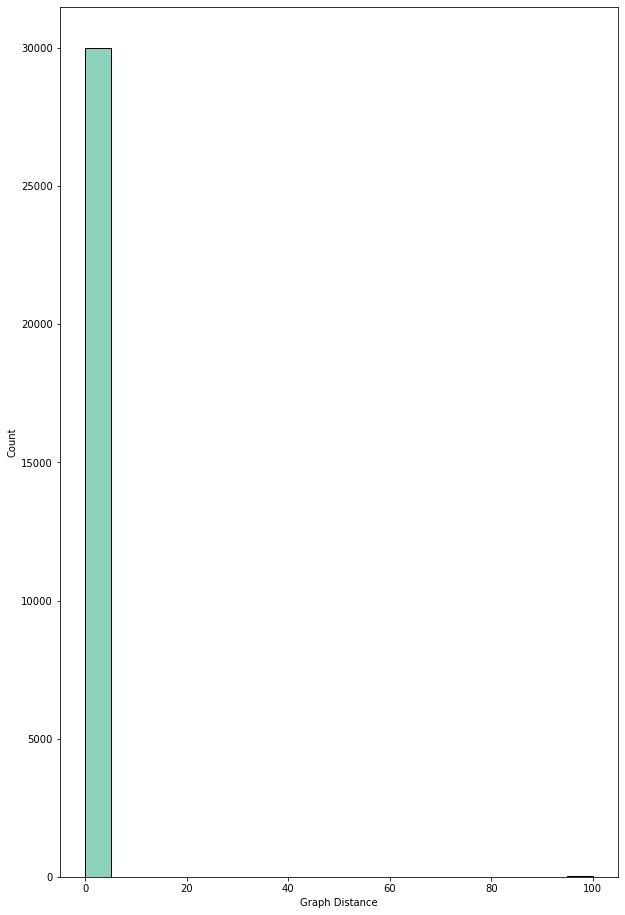

In [323]:
fig = plt.figure(figsize=(10,16))
sns.histplot(g_diff2,binwidth=5)
plt.xlabel("Graph Distance")
plt.savefig('Pong_semantic_train_hist.png')

In [126]:
G1=env.graph_list[ranks[wrong[worst][0]]]

In [127]:
G2=env.graph_list[wrong[worst][0]]

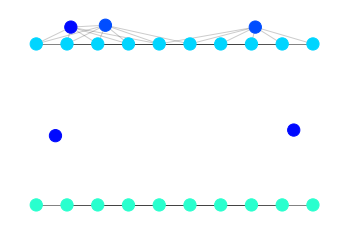

In [128]:
visualize_graph(G1)

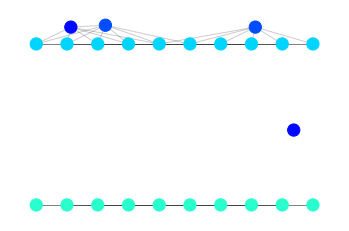

In [129]:
visualize_graph(G2)

In [130]:
graph_diff(G1,G2)

100.0

In [135]:
state_list=np.load("Pong_Example_Run.npy")
Graphs=[]
Label_imgs=[]
emb=[]
for state in state_list:
    label_img,regions,labels,emmbedding=env.preprocess_state(state)
    Graphs.append(regions_to_graph(regions,labels,prox=env.prox))
    Label_imgs.append(label_img)
    emb.append(emmbedding)

In [136]:
ranks2=[]

In [137]:
for x in emb:
    sims = model.dv.most_similar([x], topn=1)
    ranks2.append(sims[0][0])

In [252]:
valid_diff=np.array([graph_diff(Graphs[i],env.graph_list[ranks2[i]]) for i in range(len(ranks2))])

In [332]:
np.mean(valid_diff<5)

0.6658249158249159

In [255]:
graph_diff(Graphs[100],env.graph_list[ranks2[100]])

2.0

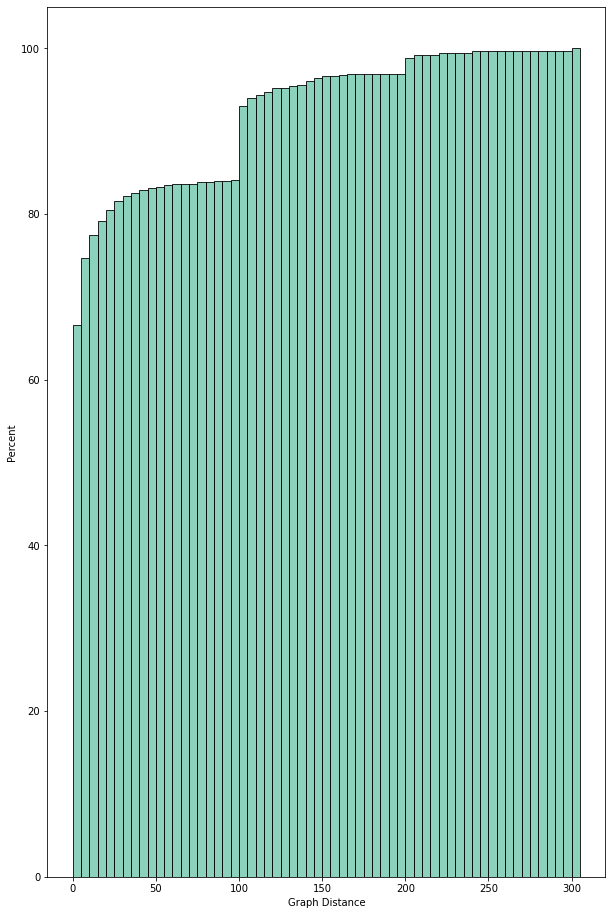

In [327]:
fig = plt.figure(figsize=(10,16))
sns.histplot(np.round(valid_diff,2),cumulative=True,stat="percent",binwidth=5)
plt.xlabel("Graph Distance")
plt.savefig('Pong_semantic_val_cum_hist.png')

In [ ]:
Pong_semantic_val_hist

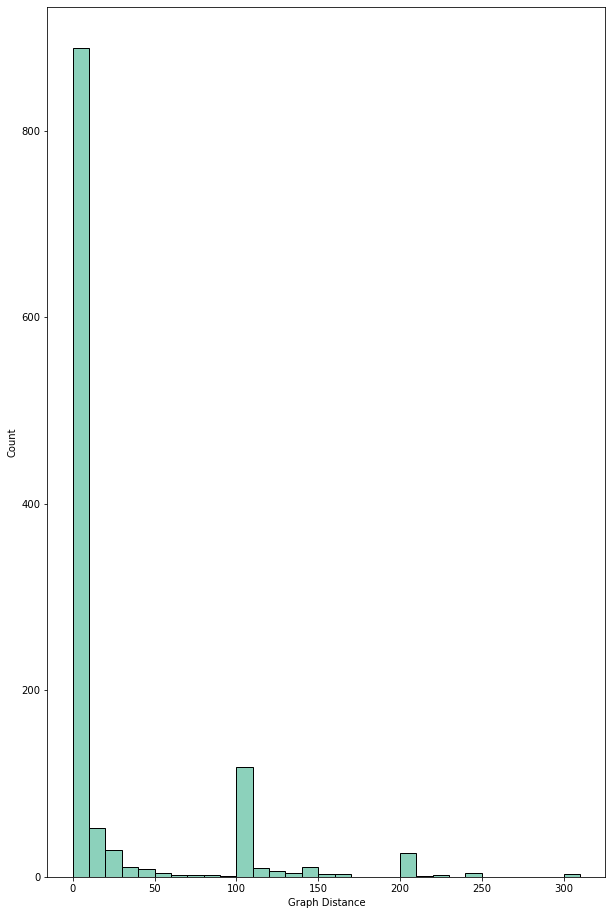

In [331]:
fig = plt.figure(figsize=(10,16))
sns.histplot(valid_diff,binwidth=10)
plt.xlabel("Graph Distance")
plt.savefig('Pong_semantic_val_hist.png')

In [184]:
worst=np.argmax(valid_diff)

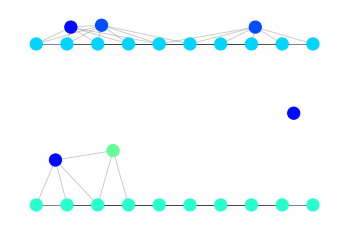

In [186]:
visualize_graph(env.graph_list[ranks2[worst]])

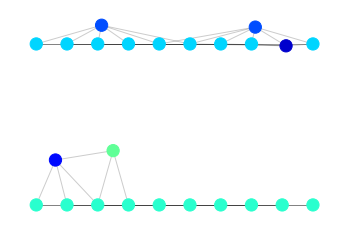

In [187]:
visualize_graph(Graphs[worst])

In [285]:
def graph_diff3(l1,l2,obj_class_diff=100,obj_n_diff=100):

    if len(l1)==0 or len(l2)==0:
        return abs(len(l1)-len(l2))*obj_n_diff
    
    if len(l1)>len(l2):
        l1,l2 = l2,l1
    
    c1=np.array([[l[1],l[2]] for l in l1])
    c2=np.array([[l[1],l[2]] for l in l2])
    
    lab1=np.array([[int(l[0])] for l in l1])
    lab2=np.array([[int(l[0])] for l in l2])
    
    dist=euclidean_distances(c1,c2)+obj_class_diff*(euclidean_distances(lab1,lab2)>0)
        
    return np.sum(np.min(dist,axis=1))+abs(dist.shape[0]-dist.shape[1])*obj_n_diff

In [286]:
def graph_diff_list(G1_list,G2_list,obj_class_diff=100,obj_n_diff=100):
    L1=[[(G1.nodes[x]["feature"],G1.nodes[x]["position_x"],G1.nodes[x]["position_y"]) for x in G1.nodes] for G1 in G1_list]
    L2=[[(G2.nodes[x]["feature"],G2.nodes[x]["position_x"],G2.nodes[x]["position_y"]) for x in G2.nodes] for G2 in G2_list]
    
    dist=np.zeros((len(L1),len(L2)))
    for x in range(len(L1)):
        for y in range(len(L2)):
            dist[x,y]=graph_diff3(L1[x],L2[y])
            if dist[x,y]==0:
                break
        
    return dist

In [161]:
%time graph_diff(Graphs[10],env.graph_list[12])

CPU times: user 2.66 ms, sys: 0 ns, total: 2.66 ms
Wall time: 2.79 ms


200.0

In [189]:
from joblib import Parallel, delayed

In [287]:
%%time
n_cores = 6
parallel = Parallel(n_jobs=n_cores)
results = parallel(delayed(graph_diff_list)(Graphs,env.graph_list[i::n_cores]) for i in range(n_cores))
#results=np.vstack(results).flatten()

CPU times: user 3.3 s, sys: 1.15 s, total: 4.44 s
Wall time: 1h 8min 43s


In [288]:
results2=np.hstack(results)

In [289]:
graph_diff(Graphs[101],env.graph_list[ranks2[101]])

1.0

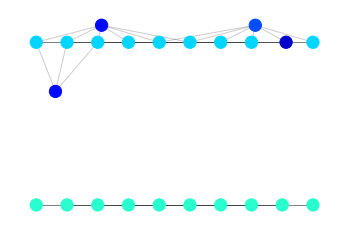

In [290]:
visualize_graph(Graphs[101])

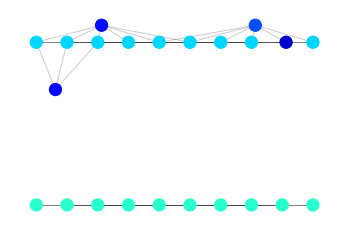

In [291]:
visualize_graph(env.graph_list[ranks2[101]])

In [292]:
graph_diff_list([Graphs[101]],[env.graph_list[ranks2[101]]])

array([[1.]])

In [293]:
graph_diff_list([Graphs[101]],[env.graph_list[ranks2[101]]])

array([[1.]])

In [338]:
np.mean(valid_diff<200)/np.mean(G_test2<200)

0.9696969696969697

In [295]:
G_test2=np.min(results2,axis=1)

In [309]:
np.mean(valid_diff<100)/np.mean(G_test2<100)

0.8416175231676496

In [300]:
df_2=pd.DataFrame({"Distance":np.concatenate([valid_diff,G_test2]),"Embedding":np.concatenate([np.ones(len(valid_diff)),np.zeros(len(G_test2))])})

In [305]:
df_2["Embedding"]=df_2["Embedding"].astype("int")

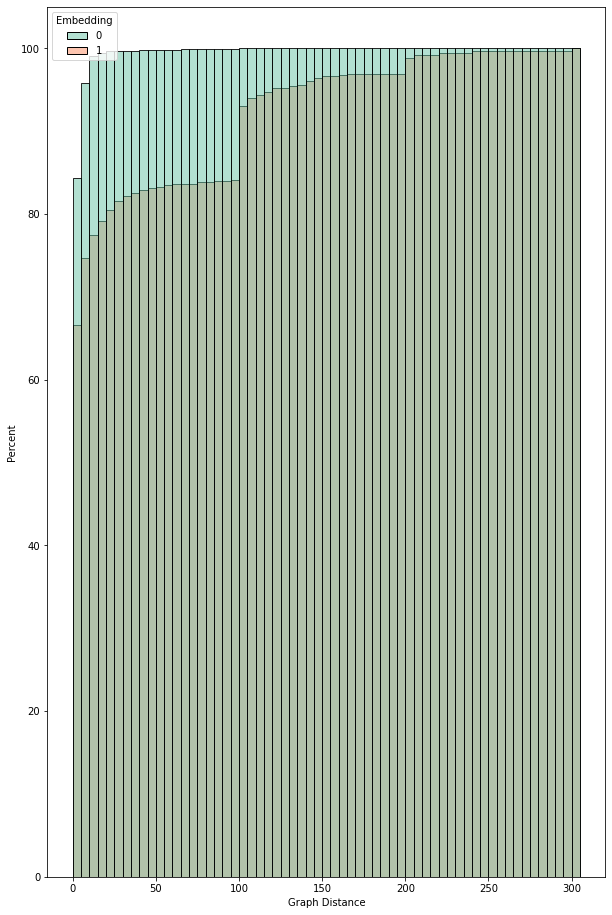

In [328]:
fig = plt.figure(figsize=(10,16))
sns.histplot(data=df_2,x="Distance",cumulative=True,stat="percent",hue="Embedding",common_norm=False,binwidth=5)
plt.xlabel("Graph Distance")
plt.savefig('Pong_semantic_val_cum_hist.png')

In [193]:
%time G_test=graph_diff_list(Graphs[0:1000],env.graph_list[0:100])

CPU times: user 50.7 s, sys: 0 ns, total: 50.7 s
Wall time: 51.3 s


In [163]:
def cosine_similarity(x, y):
    
    # Ensure length of x and y are the same
    if len(x) != len(y) :
        return None
    
    # Compute the dot product between x and y
    dot_product = np.dot(x, y)
    
    # Compute the L2 norms (magnitudes) of x and y
    magnitude_x = np.sqrt(np.sum(x**2)) 
    magnitude_y = np.sqrt(np.sum(y**2))
    
    # Compute the cosine similarity
    cosine_similarity = dot_product / (magnitude_x * magnitude_y)
    
    return cosine_similarity

In [339]:
X=np.array(emb)

In [340]:
changes=(np.abs(X[1:]-X[0:-1])).mean(axis=-1)

In [341]:
changes=np.array([cosine_similarity(X[i+1],X[i]) for i in range(len(Graphs)-1)])

In [342]:
G_diff=np.array([graph_diff(Graphs[i],Graphs[i+1]) for i in range(len(Graphs)-1)])

In [343]:
m, b = np.polyfit(changes, G_diff, 1)

In [344]:
np.min(changes)

-0.07498352

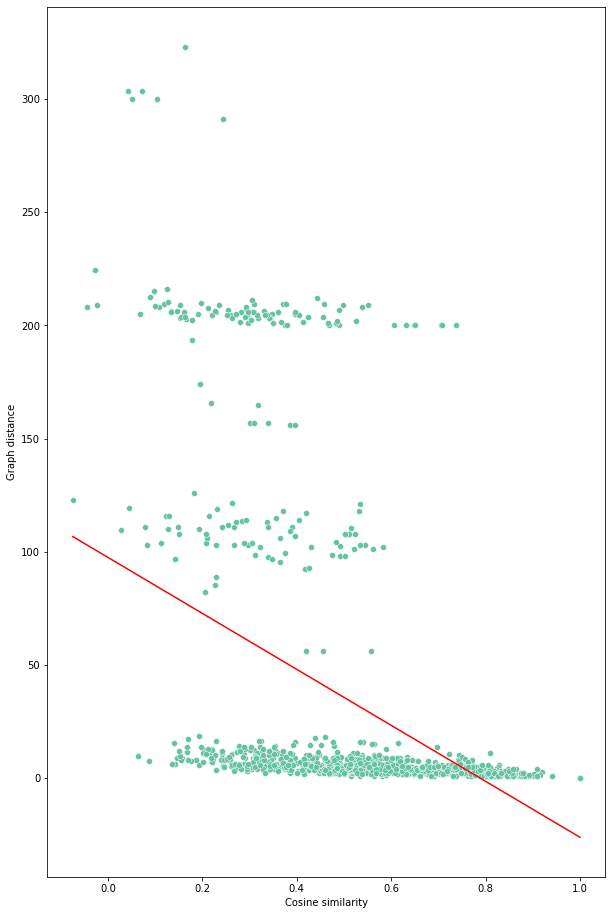

In [345]:
fig = plt.figure(figsize=(10,16))
sns.scatterplot(x=changes,y=G_diff)
plt.plot([np.min(changes),np.max(changes)], [np.min(changes)*m + b,np.max(changes)*m + b],c="red")
plt.xlabel("Cosine similarity")
plt.ylabel("Graph distance")
plt.savefig('Pong_val_correlation.png')

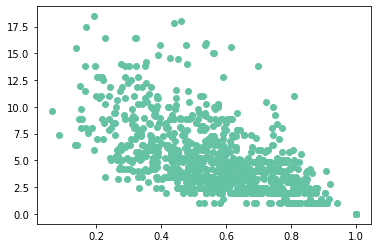

In [346]:
plt.scatter(changes[G_diff<50],G_diff[G_diff<50])

In [347]:
np.corrcoef(changes,G_diff)

array([[ 1.        , -0.46328484],
       [-0.46328484,  1.        ]])

In [175]:
np.corrcoef(changes[G_diff<50],G_diff[G_diff<50])

array([[ 1.        , -0.67539389],
       [-0.67539389,  1.        ]])

In [348]:
X=np.array(emb)

In [349]:
brc = Birch(n_clusters=32,threshold=0.5).fit(X)

In [350]:
lab=brc.labels_

In [351]:
metrics.silhouette_score(X, lab, metric='euclidean')

0.09226871

In [352]:
metrics.davies_bouldin_score(X, lab)

2.528671881514425

In [353]:
d = euclidean_distances(X)

dunn.dunn(lab,d)

0.30920385573795595

<AxesSubplot:xlabel='x', ylabel='y'>

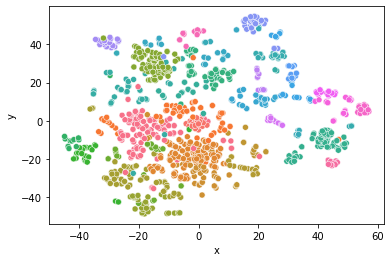

In [354]:
X_embedded = TSNE(n_components=2, init='random').fit_transform(X)

df = pd.DataFrame(np.concatenate((X_embedded[:,:2],lab.reshape(-1,1)),axis=-1), columns=["x", "y","z"])
df["z"]=df["z"].astype("int").astype("str")
sns.scatterplot(data=df,x="x",y="y",hue="z", legend=None)

In [401]:
X=env.pca_list[100]

In [403]:
estimator=env.image_seg

In [404]:
from sklearn.utils import gen_batches
from joblib import Parallel, delayed

n_jobs = 4
n_samples, n_features = X.shape
batch_size = n_samples//n_jobs

def _predict(method, X, sl):
    return method(X[sl])

Parallel(n_jobs)(delayed(_predict)(estimator.predict, X, sl)
                 for sl in gen_batches(n_samples, batch_size))

[array([4, 4, 2, 2, 6, 0]),
 array([0, 0, 0, 0, 0, 0]),
 array([0, 0, 0, 7, 7, 7]),
 array([7, 7, 7, 7, 7, 7]),
 array([7])]

In [407]:
%timeit Parallel(n_jobs)(delayed(_predict)(estimator.predict, X, sl) for sl in gen_batches(n_samples, batch_size))

10.4 ms ± 110 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [409]:
%timeit env.step(0)

5.06 ms ± 192 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [410]:
%timeit env.preprocess_state(test)

4.06 ms ± 20.2 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [284]:
def pred_core():
    n_cores = 3
    parallel = Parallel(n_jobs=n_cores)
    results = parallel(delayed(clf.predict)(to_be_predicted[i].reshape(-1,3))
        for i in range(n_cores))

    return np.vstack(results).flatten()

In [286]:
%time clf.predict(to_be_predicted)

CPU times: user 1.94 ms, sys: 18 µs, total: 1.96 ms
Wall time: 1.71 ms


array([0, 0, 0])

In [300]:
%time pred_core()

CPU times: user 8.06 ms, sys: 4.04 ms, total: 12.1 ms
Wall time: 10.6 ms


array([0, 0, 0])

In [378]:
%time env.reset()

CPU times: user 10.7 ms, sys: 0 ns, total: 10.7 ms
Wall time: 10.5 ms


array([0., 0., 0., ..., 0., 0., 0.])

In [379]:
%time env.step(0)

CPU times: user 9.7 ms, sys: 15 µs, total: 9.71 ms
Wall time: 8.42 ms


(array([0.        , 0.        , 0.        , ..., 0.39266775, 0.39266775,
        0.18517829]),
 0.0,
 False,
 {'lives': 0, 'episode_frame_number': 4, 'frame_number': 6220})

In [414]:
env.pca_obj.explained_variance_ratio_.sum()

0.9909245415086192

In [415]:
centers=env.pca_obj.inverse_transform(env.image_seg.subcluster_centers_).reshape(env.image_seg.subcluster_centers_.shape[0],10,8,1)

In [416]:
centers=centers[np.argsort(env.image_seg.subcluster_labels_)]

In [417]:
env.pca_obj.explained_variance_ratio_.sum()

0.9909245415086192

In [418]:
labels_s=np.sort(env.image_seg.subcluster_labels_)

In [419]:
centers.shape

(8, 10, 8, 1)

In [420]:
labels_s

array([0, 1, 2, 3, 4, 5, 6, 7])

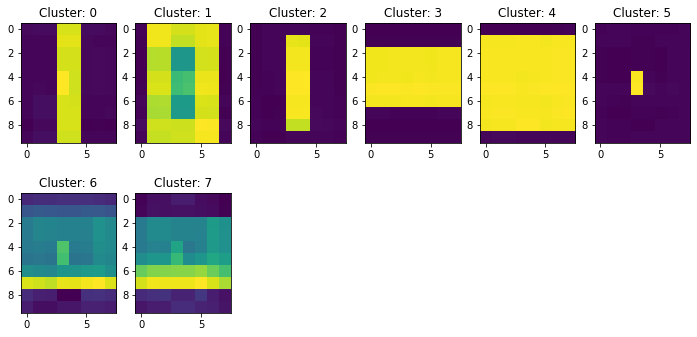

In [421]:
size=4
i=1
fig = plt.figure(figsize=(12,12))
for i in range(centers.shape[0]):
    fig.add_subplot(4, 6,i+1)
    plt.imshow(centers[i])
    plt.title("Cluster: "+str(labels_s[i]))
#     for k in range(4):
#         plt.title("Cluster: "+str(label))
#         fig.add_subplot(size, size,i)
#         plt.imshow(ob)
#         i+=1
plt.savefig('Pong_clusters.png')

In [422]:
class PongRamEnvironment(gym.Wrapper):

    def __init__(self, env):
        gym.Wrapper.__init__(self, env)
        self.repeat_action=4
        self.last_state=np.zeros(4)
        self.observation_space = gym.spaces.Box(low=-2.0, high=2.0, shape=(8,), dtype=np.float32)
        self.action_space=spaces.Discrete(2)
        
    def preprocess_state(self, state):
        #cpu_score = ram[13]  # computer/ai opponent score 
        #player_score = ram[14]  # your score
        cpu_paddle_y = state[21]  # Y coordinate of computer paddle
        player_paddle_y = state[51]  # Y coordinate of your paddle
        ball_x = state[49]  # X coordinate of ball
        ball_y = state[54]  # Y coordinate of ball
        obs = np.array([cpu_paddle_y, player_paddle_y, ball_x, ball_y], dtype=np.float32)/255.0
        return obs


    def reset(self, **kwargs):
        self.env.reset(**kwargs)
        state = np.zeros((2,4))
        self.last_state=np.zeros(4)
        return state.reshape(-1)

    def step(self, actions):
        
        #actions mapped
        actions={0:2,1:3}[actions]
        total_reward=0
        next_state=np.zeros((2,4))
        for i in range(self.repeat_action):
            state, reward, terminal, info = self.env.step(actions)
            total_reward += reward
            if terminal:
                break
        
        state=self.preprocess_state(state)
        next_state[0,:] = state
        next_state[1,:] = state-self.last_state
        self.last_state=state
        
        return next_state.reshape(-1), total_reward, terminal, info

In [228]:
class ActionWrapper(gym.ActionWrapper):
    def __init__(self, env):
        super().__init__(env)
        self.action_space=spaces.Discrete(2)
    
    def action(self, act):
        act={0:2,1:3,2:2}[act]
        return act

In [229]:
env_id = "PongNoFrameskip-v4"
env    = make_atari(env_id)
env    = ActionWrapper(env)
env    = wrap_deepmind(env)
env    = wrap_pytorch(env)

In [47]:
env=gym.make('Pong-ramNoFrameskip-v4')

env=PongRamEnvironment(env)

In [423]:
class CnnDQN(nn.Module):
    def __init__(self, input_shape, num_actions):
        super(CnnDQN, self).__init__()
        
        self.input_shape = input_shape
        self.num_actions = num_actions
        
        self.features = nn.Sequential(
            nn.Conv2d(input_shape[0], 32, kernel_size=8, stride=4),
            nn.ReLU(),
            nn.Conv2d(32, 64, kernel_size=4, stride=2),
            nn.ReLU(),
            nn.Conv2d(64, 64, kernel_size=3, stride=1),
            nn.ReLU()
        )
        
        self.fc = nn.Sequential(
            nn.Linear(self.feature_size(), 256),
            nn.ReLU(),
            nn.Linear(256, self.num_actions)
        )
        
    def forward(self, x):
        x = self.features(x)
        x = x.view(x.size(0), -1)
        x = self.fc(x)
        return x
    
    def feature_size(self):
        return self.features(autograd.Variable(torch.zeros(1, *self.input_shape))).view(1, -1).size(1)
    
    def act(self, state, epsilon):
        if random.random() > epsilon:
            with torch.no_grad():
                state   = Variable(torch.FloatTensor(np.float32(state)).unsqueeze(0))
                
            q_value = self.forward(state)
            action  = q_value.max(1)[1].item()
        else:
            action = random.randrange(env.action_space.n)
        return action

In [356]:
model = DQN(env.observation_space.shape, env.action_space.n)

if USE_CUDA:
    model = model.cuda()
    
optimizer = optim.Adam(model.parameters(), lr=0.00001)

replay_initial = 10000
replay_buffer = ReplayBuffer(100000)

In [357]:
model

DQN(
  (layers): Sequential(
    (0): Linear(in_features=256, out_features=256, bias=True)
    (1): ReLU()
    (2): Linear(in_features=256, out_features=3, bias=True)
  )
)

In [358]:
epsilon_start = 1.0
epsilon_final = 0.01
epsilon_decay = 30000

epsilon_by_frame = lambda frame_idx: epsilon_final + (epsilon_start - epsilon_final) * math.exp(-1. * frame_idx / epsilon_decay)

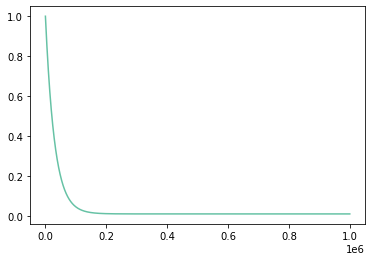

In [359]:
plt.plot([epsilon_by_frame(i) for i in range(1000000)])

In [360]:
import datetime

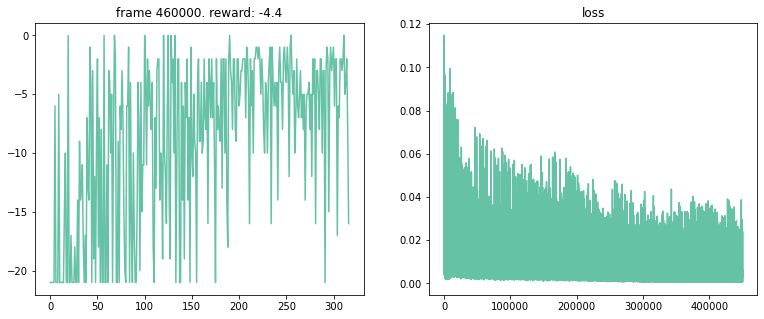

36.79151837768535 frames per sec


RuntimeError: CUDA error: unspecified launch failure
CUDA kernel errors might be asynchronously reported at some other API call,so the stacktrace below might be incorrect.
For debugging consider passing CUDA_LAUNCH_BLOCKING=1.

In [361]:
num_frames = 1400000
batch_size = 32
gamma      = 0.99

losses = []
all_rewards = []
episode_reward = 0
tic = datetime.datetime.now()

state = env.reset()
for frame_idx in range(1, num_frames + 1):
    epsilon = epsilon_by_frame(frame_idx)
    action = model.act(state, epsilon)
    
    next_state, reward, done, _ = env.step(action)
    replay_buffer.push(state, action, reward, next_state, done)
    
    state = next_state
    episode_reward += reward
    
    if done:
        state = env.reset()
        all_rewards.append(episode_reward)
        episode_reward = 0
        
    if len(replay_buffer) > replay_initial:
        loss = compute_td_loss(batch_size)
        losses.append(loss.item())
        
    if frame_idx % 10000 == 0:
        plot(frame_idx, all_rewards, losses)
        tac = datetime.datetime.now()
        print(str(10000/(tac-tic).total_seconds())+" frames per sec")
        tic = tac

In [373]:
torch.save(model, "model/my_model.pt")

RuntimeError: CUDA error: unspecified launch failure
CUDA kernel errors might be asynchronously reported at some other API call,so the stacktrace below might be incorrect.
For debugging consider passing CUDA_LAUNCH_BLOCKING=1.

In [ ]:
model = torch.load(PATH)
model.eval()

In [363]:
def moving_average(x, w):
    return np.convolve(x, np.ones(w), 'valid') / w

In [365]:
a_r=moving_average(all_rewards,10)

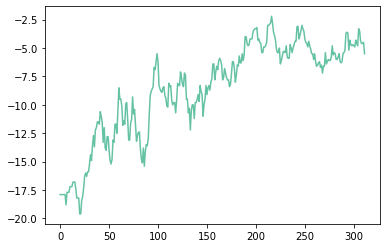

In [366]:
plt.plot(a_r)

In [19]:
def show_image(img):
    fig, ax = plt.subplots(figsize=(10, 6))
    ax.imshow(img)

In [371]:
USE_CUDA=True

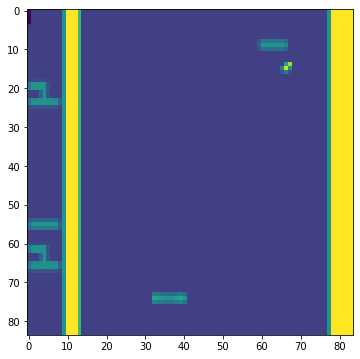

In [50]:
show_image(state_list[1])

In [368]:
env.keep_state_list=True

In [369]:
env.state_list=[]

In [372]:
state_list=[]
state = env.reset()
episode_reward=0
for frame_idx in range(1, 10000):
    epsilon = 0.01
    action = model.act(state, epsilon)
    next_state, reward, done, _ = env.step(action)
    
    state = next_state
    episode_reward += reward
    state_list.append(state)
    if done:
        state = env.reset()
        break

RuntimeError: CUDA error: unspecified launch failure
CUDA kernel errors might be asynchronously reported at some other API call,so the stacktrace below might be incorrect.
For debugging consider passing CUDA_LAUNCH_BLOCKING=1.

In [449]:
temp=np.array([state_list[i][0:1100].reshape(11,10,10)[0,:,:] for i in range(len(state_list))])

In [459]:
len(state_list)

6698

In [460]:
episode_reward

-9.0

In [59]:
import cv2

In [458]:
def make_video(States,name="test",width=160,height=210,channel=3,fps=60):
    fourcc = cv2.VideoWriter_fourcc(*'XVID') 
    video = cv2.VideoWriter(name+'.avi', fourcc, float(fps), (width,height), 1)

    for i in range(States.shape[0]):
        video.write(States[i])

    video.release()

In [394]:
from skimage.color import label2rgb, rgb2gray, gray2rgb

In [461]:
make_video(np.array(env.state_list),name="torch4",width=160,height=210)

In [41]:
np.array(state_list).shape

(893, 1, 84, 84)

In [85]:
state_list

array([[[ 52,  87,  87, ..., 236, 236, 236],
        [ 52,  87,  87, ..., 236, 236, 236],
        [ 52,  87,  87, ..., 236, 236, 236],
        ...,
        [ 87,  87,  87, ..., 236, 236, 236],
        [ 87,  87,  87, ..., 236, 236, 236],
        [ 87,  87,  87, ..., 236, 236, 236]],

       [[ 52,  87,  87, ..., 236, 236, 236],
        [ 52,  87,  87, ..., 236, 236, 236],
        [ 52,  87,  87, ..., 236, 236, 236],
        ...,
        [ 87,  87,  87, ..., 236, 236, 236],
        [ 87,  87,  87, ..., 236, 236, 236],
        [ 87,  87,  87, ..., 236, 236, 236]],

       [[ 52,  87,  87, ..., 236, 236, 236],
        [ 52,  87,  87, ..., 236, 236, 236],
        [ 52,  87,  87, ..., 236, 236, 236],
        ...,
        [ 87,  87,  87, ..., 236, 236, 236],
        [ 87,  87,  87, ..., 236, 236, 236],
        [ 87,  87,  87, ..., 236, 236, 236]],

       ...,

       [[ 52,  87,  87, ..., 236, 236, 236],
        [ 52,  87,  87, ..., 236, 236, 236],
        [ 52,  87,  87, ..., 236, 236, 236

In [37]:
temp=np.hstack((state_list,state_list,state_list))

In [38]:
temp=temp.reshape(-1,84,84,3)

In [39]:
make_video(temp,name="torch2",width=84,height=84)

In [72]:
state_list[5]

array([[ 52,  87,  87, ..., 236, 236, 236],
       [ 52,  87,  87, ..., 236, 236, 236],
       [ 52,  87,  87, ..., 236, 236, 236],
       ...,
       [ 87,  87,  87, ..., 236, 236, 236],
       [ 87,  87,  87, ..., 236, 236, 236],
       [ 87,  87,  87, ..., 236, 236, 236]], dtype=uint8)

In [73]:
state_list[5].sha

array([[ 52,  87,  87, ..., 236, 236, 236],
       [ 52,  87,  87, ..., 236, 236, 236],
       [ 52,  87,  87, ..., 236, 236, 236],
       ...,
       [ 87,  87,  87, ..., 236, 236, 236],
       [ 87,  87,  87, ..., 236, 236, 236],
       [ 87,  87,  87, ..., 236, 236, 236]], dtype=uint8)